<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Sandford_Generation_Daily_Correlation_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sandford Generation Daily Correlation Exploration

Author: Ravi Kohli

Date: November 20th, 2020

College: Christ Church

**Goal:** Do some basic correlation analysis between the daily gneeration data provided by David and the Radcliffe Observatory data

In [1]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pickle
from matplotlib.dates import DateFormatter
from scipy.stats import pearsonr
from scipy import signal

## Retrieving & Merging the Data

In [3]:
# unpickle the precipitation daily dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_precipitation_data_processed'
infile = open(path+filename, 'rb')
precipitation_daily_df = pickle.load(infile)
infile.close()

In [4]:
# unpickle the temperature daily dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'radcliffe_daily_temperature_data_processed'
infile = open(path+filename, 'rb')
temperature_daily_df = pickle.load(infile)
infile.close()

In [5]:
# unpickle the processed daily generation dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'daily_sandford_generation_data'
infile = open(path+filename, 'rb')
sandford_daily_df = pickle.load(infile)
infile.close()

In [6]:
# unpickle the river level dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'independent_river_level_data_processed'
infile = open(path+filename, 'rb')
river_level_df = pickle.load(infile)
infile.close()

In [7]:
# create masks for each of the dataset to extract the data from the required data ranges
precipitation_mask = (precipitation_daily_df['Date'] >= sandford_daily_df['Reading Date'].values[-1]) & (precipitation_daily_df['Date'] <= sandford_daily_df['Reading Date'].values[0])
temperature_mask = (temperature_daily_df['Date'] >= sandford_daily_df['Reading Date'].values[-1]) & (temperature_daily_df['Date'] <= sandford_daily_df['Reading Date'].values[0])
river_level_mask = (river_level_df['date'] >= sandford_daily_df['Reading Date'].values[-1]) & (river_level_df['date'] <= sandford_daily_df['Reading Date'].values[0])

In [8]:
# new dataframes that have extracted data within the required ranges
extracted_precipitation_df = precipitation_daily_df[precipitation_mask]
extracted_temperature_df = temperature_daily_df[temperature_mask]
extracted_river_level_df = river_level_df[river_level_mask]

In [9]:
# reset the indices of the dataframes
extracted_precipitation_df.reset_index(inplace = True)
extracted_temperature_df.reset_index(inplace = True)
extracted_river_level_df.reset_index(inplace = True)

In [10]:
# this cell prints the day that is missing in the Sandford daily generation data
set_p = set(extracted_precipitation_df['Date'])     # creating a set of the precipitation data
set_d = set(sandford_daily_df['Reading Date'])      # creating a set of the generation data
missing_date = list(set_p.difference(set_d))
print(missing_date[0])                                 

2019-06-01 00:00:00


In [11]:
# merging the generation and precipitation dataframes
merge = extracted_precipitation_df[['Date', 'Rainfall mm 1 dpl no traces']].merge(sandford_daily_df, left_on= 'Date', right_on='Reading Date',  how='left')

# merging the merge dataframe with the temperature dataframe
merge = merge.merge(extracted_temperature_df, on='Date', how='left')

# merge the dataframe with the river level dataframe
merge = merge.merge(extracted_river_level_df, left_on = 'Date', right_on = 'date', how = 'left')

In [12]:
# just accessing the index of the row with the missing date
f = merge.index[merge['Date'] == missing_date[0]].tolist()
merge.iloc[f]

,Date,Rainfall mm 1 dpl no traces,Reading Date,Incremental Reading,Meter Reading,index_x,Tmax °C,Tmin °C,Daily Tmean °C,Daily range degC,index_y,date,min_level,avg_level,max_level
226,2019-06-01,0.0,NaT,NaN,NaN,74661,26.5,11.2,18.9,15.3,2369,2019-06-01,0.042,0.097,0.143


In [13]:
# create masks for the zoomed in data sets
start = 120
end = 200
zoomed_mask = (merge['Date'] >= sandford_daily_df['Reading Date'].values[-1-start]) & (merge['Date'] <= sandford_daily_df['Reading Date'].values[end])

In [14]:
zoomed_merge = merge[zoomed_mask]         # create the zoomed in dataframe to be used in the zoomed in analysis

# Comparison with Precipitation Level Data

We are now going to plot the Sandford Hydro generation data and overlay the precipitation data on top of it

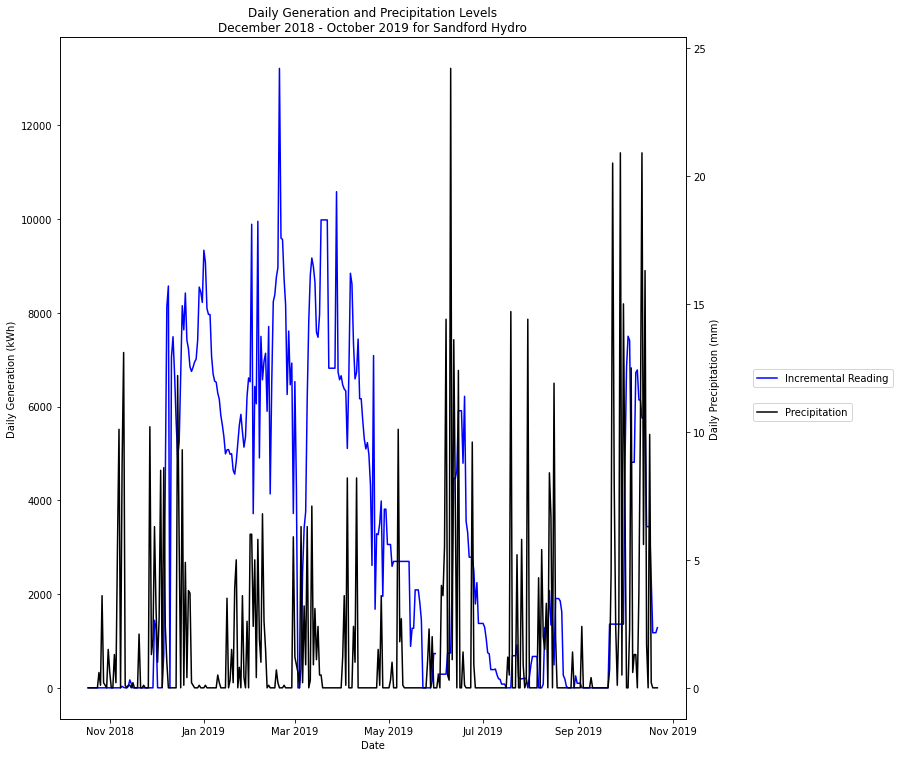

In [15]:
daily_gp_fig, daily_gp_ax = plt.subplots(figsize=(10, 10))                      # gp means generation-precipitation
daily_gp_ax2 = daily_gp_ax.twinx()                                              # instantiate a second axes that shares the same x-axis

# Add x-axis and y-axis to the bar chart
# Overlaying the precipitation data on top of the hydro generation data
daily_gp_ax.plot(merge['Date'].values, merge['Incremental Reading'], color='blue', label='Incremental Reading' )
daily_gp_ax2.plot(merge['Date'].values, merge['Rainfall mm 1 dpl no traces'], color='k', label='Precipitation' )
daily_gp_ax2.set_ylabel('Daily Precipitation (mm)')                             # we already handled the x-label with ax1

daily_gp_fig.tight_layout()                                                     # otherwise the right y-label is slightly clipped

# Set title and labels for axes
daily_gp_ax.set(xlabel= "Date", ylabel= "Daily Generation (kWh)", title= "Daily Generation and Precipitation Levels\nDecember 2018 - October 2019 for Sandford Hydro")

# Change the date format if we want
date_form = DateFormatter('%b %Y') #DateFormatter("%m-%d")
daily_gp_ax.xaxis.set_major_formatter(date_form)
daily_gp_ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
daily_gp_ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.45))
plt.show()

**Results from the Graph:** 
- Similar to the monthly graph, the above graph shows that generation was higher when precipitation levels tended to be lower. It would be interesting for me to run a correlation analysis on this data
- There also does seem to be some time lag between the datasets, and so I could even make another plot which is zoomed into specific months to get a look in greater detail

## Correlation Calculations of the Generation Data with Precipitation Levels over the whole time period

**Hypothesis**: Is there a correlation between the precipitation levels and the generation data? (for time lag $ = 0 $)

In [16]:
# filling all the NaN values within the columns with zeros
merge['Incremental Reading'] = merge['Incremental Reading'].fillna(0)

In [17]:
# calculate Pearson's correlation between the generation data and the precipitation levels
corr_gp, _ = pearsonr(merge['Incremental Reading'], merge['Rainfall mm 1 dpl no traces'])
print('Pearsons correlation: %.3f' % corr_gp)       

Pearsons correlation: -0.021


We are using $ n = 370 $ data points, and thus the hypothesis test will have $ n - 2 = 368 $ degrees of freedom

Looking at a table for 2-tailed hypothesis tests for correlation coefficients, we can see that this value is not greater than any of the test statistics at the following levels[1] for the 350 d.o.f row:
- 0.2: 0.068470
- 0.1: 0.087814
- 0.05: 0.104552
- 0.02: 0.123957
- 0.01: 0.137131
- 0.001: 174657


### Crosscorrelation

Text(0.5, 1.0, 'Cross-correlation between daily generation and daily precipitation')

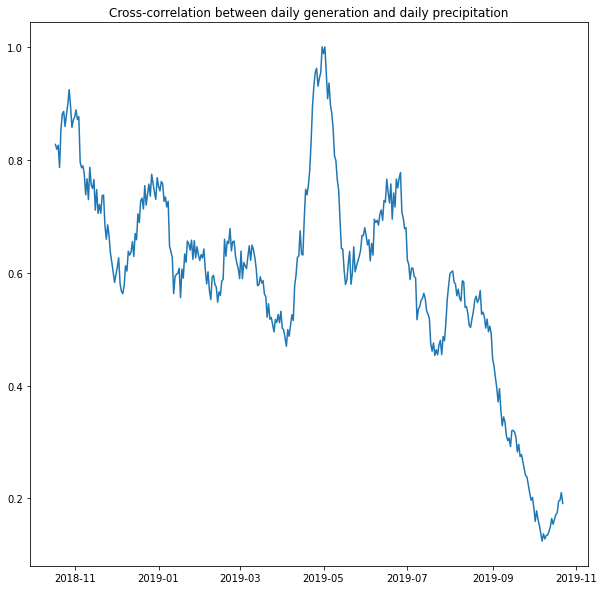

In [18]:
corr_gp = signal.correlate(merge['Incremental Reading'], merge['Rainfall mm 1 dpl no traces'], mode = 'same')   #, mode='same')
fig_corr_gp, ax_corr_gp = plt.subplots(figsize=(10, 10))   
ax_corr_gp.plot(merge['Date'], corr_gp / max(corr_gp))
ax_corr_gp.set_title('Cross-correlation between daily generation and daily precipitation')
# Change the date format if we want
#date_form = DateFormatter('%b %y') #DateFormatter("%m-%d")
#ax_corr1.xaxis.set_major_formatter(date_form)

## Correlation Analysis over a zoomed in time period

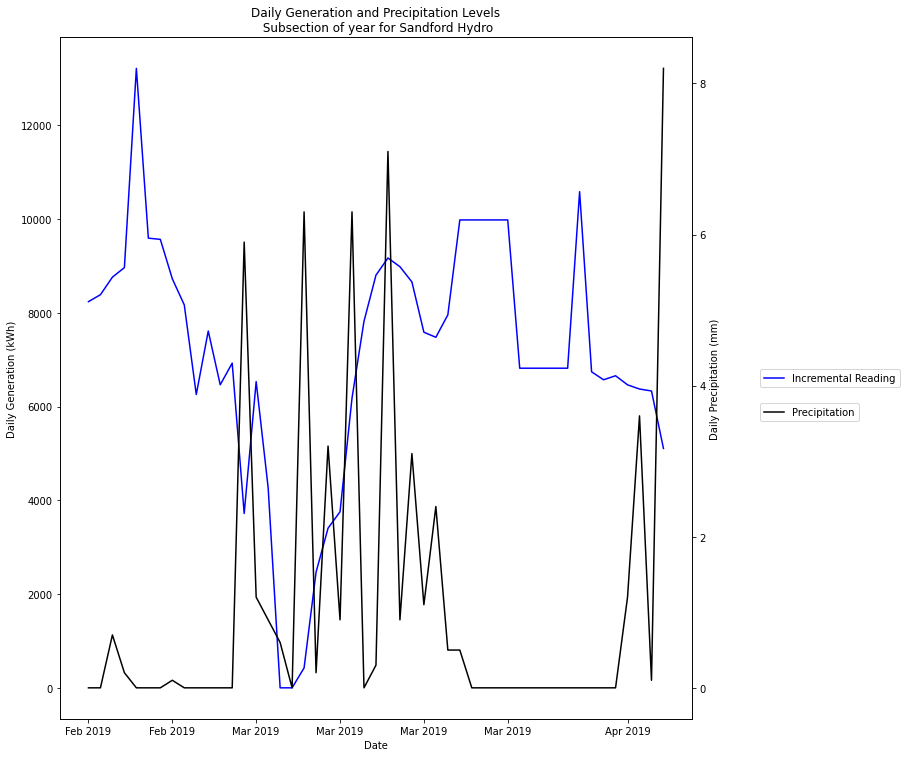

In [19]:
# create the zoomed in precipitation data
zoomed_gp_fig, zoomed_gp_ax = plt.subplots(figsize=(10, 10))                      # gp means generation-precipitation
zoomed_gp_ax2 = zoomed_gp_ax.twinx()                                              # instantiate a second axes that shares the same x-axis

# Add x-axis and y-axis to the bar chart
# Overlaying the precipitation data on top of the hydro generation data
zoomed_gp_ax.plot(zoomed_merge['Date'].values, zoomed_merge['Incremental Reading'], color='blue', label='Incremental Reading' )
zoomed_gp_ax2.plot(zoomed_merge['Date'].values, zoomed_merge['Rainfall mm 1 dpl no traces'], color='k', label='Precipitation' )
zoomed_gp_ax2.set_ylabel('Daily Precipitation (mm)')                             # we already handled the x-label with ax1

zoomed_gp_fig.tight_layout()                                                     # otherwise the right y-label is slightly clipped

# Set title and labels for axes
zoomed_gp_ax.set(xlabel= "Date", ylabel= "Daily Generation (kWh)", title= "Daily Generation and Precipitation Levels\n Subsection of year for Sandford Hydro")

# Change the date format if we want
date_form = DateFormatter('%b %Y') #DateFormatter("%m-%d")
zoomed_gp_ax.xaxis.set_major_formatter(date_form)
zoomed_gp_ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
zoomed_gp_ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.45))

plt.show()

# Comparison with River Level Data

In [20]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         370 non-null    datetime64[ns]
 1   Rainfall mm 1 dpl no traces  370 non-null    float64       
 2   Reading Date                 369 non-null    datetime64[ns]
 3   Incremental Reading          370 non-null    float64       
 4   Meter Reading                320 non-null    float64       
 5   index_x                      370 non-null    int64         
 6   Tmax °C                      370 non-null    float64       
 7   Tmin °C                      370 non-null    float64       
 8   Daily Tmean °C               370 non-null    float64       
 9   Daily range degC             370 non-null    float64       
 10  index_y                      370 non-null    int64         
 11  date                         370 non-null    

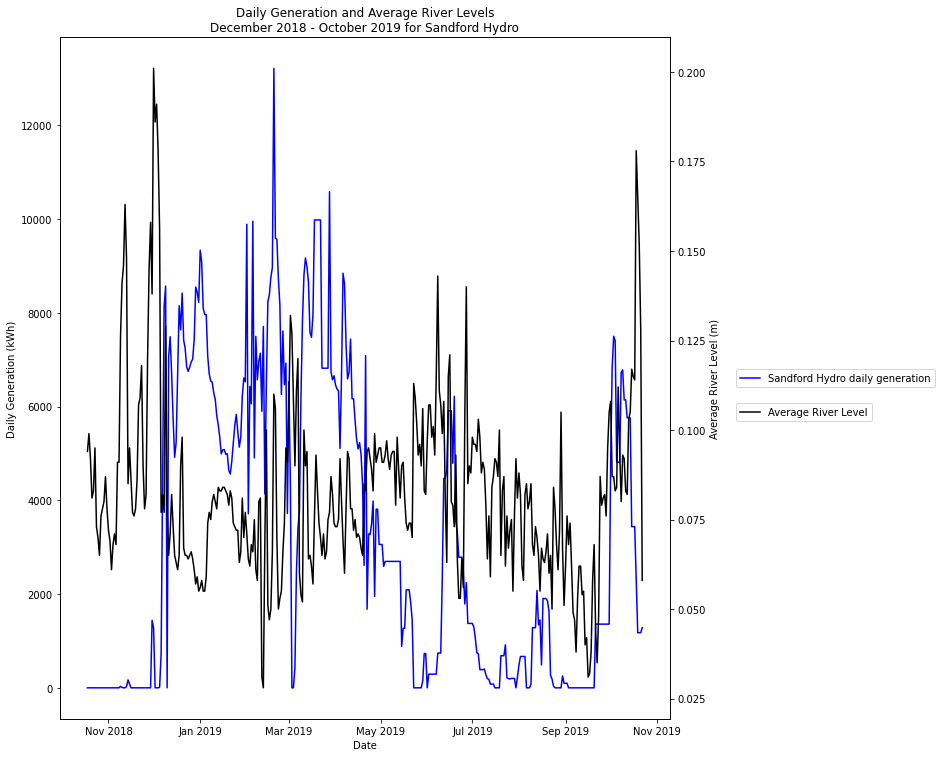

In [21]:
daily_gr_fig, daily_gr_ax = plt.subplots(figsize=(10, 10))                      # gp means generation-precipitation
daily_gr_ax2 = daily_gr_ax.twinx()                                              # instantiate a second axes that shares the same x-axis

# Add x-axis and y-axis to the bar chart
# Overlaying the precipitation data on top of the hydro generation data
daily_gr_ax.plot(merge['Date'].values, merge['Incremental Reading'], color='blue', label='Sandford Hydro daily generation')
daily_gr_ax2.plot(merge['Date'].values, merge['avg_level'], color='k', label='Average River Level' )
daily_gr_ax2.set_ylabel('Average River Level (m)')                              # we already handled the x-label with ax1

daily_gr_fig.tight_layout()                                                     # otherwise the right y-label is slightly clipped

# Set title and labels for axes
daily_gr_ax.set(xlabel= "Date", ylabel= "Daily Generation (kWh)", title= "Daily Generation and Average River Levels\nDecember 2018 - October 2019 for Sandford Hydro")

# Change the date format if we want
date_form = DateFormatter('%b %Y') #DateFormatter("%m-%d")
daily_gr_ax.xaxis.set_major_formatter(date_form)
daily_gr_ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
daily_gr_ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.45))
plt.show()

### Correlation Coefficient calculation


In [22]:
# filling all the NaN values within the columns with zeros
merge['avg_level'] = merge['avg_level'].fillna(0)

In [23]:
# calculate Pearson's correlation between the generation data and the precipitation levels
corr_gr, _ = pearsonr(merge['Incremental Reading'], merge['avg_level'])
print('Pearsons correlation: %.3f' % corr_gr)  

Pearsons correlation: -0.217


### Cross-correlation

Text(0.5, 1.0, 'Cross-correlation between daily generation and daily average river level')

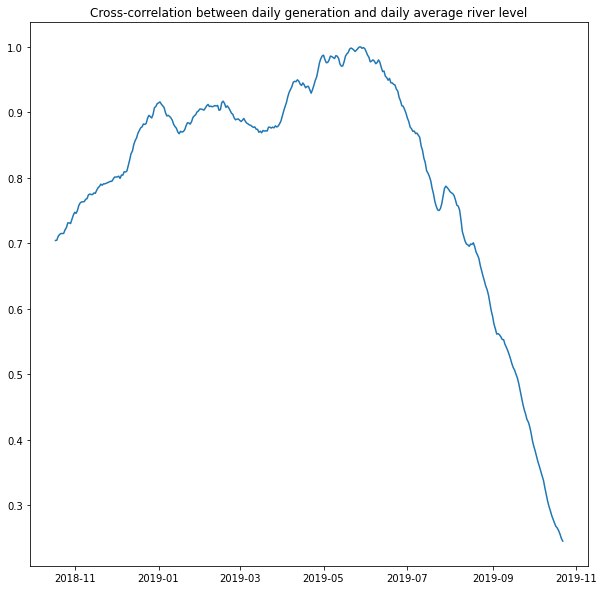

In [24]:
corr_gr = signal.correlate(merge['Incremental Reading'], merge['avg_level'], mode = 'same')   
fig_corr_gr, ax_corr_gr = plt.subplots(figsize=(10, 10))   
ax_corr_gr.plot(merge['Date'], corr_gr / max(corr_gr))
ax_corr_gr.set_title('Cross-correlation between daily generation and daily average river level')
# Change the date format if we want
#date_form = DateFormatter('%b %y') #DateFormatter("%m-%d")
#ax_corr1.xaxis.set_major_formatter(date_form)

# Comparison with Temperature Data

In [25]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370 entries, 0 to 369
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         370 non-null    datetime64[ns]
 1   Rainfall mm 1 dpl no traces  370 non-null    float64       
 2   Reading Date                 369 non-null    datetime64[ns]
 3   Incremental Reading          370 non-null    float64       
 4   Meter Reading                320 non-null    float64       
 5   index_x                      370 non-null    int64         
 6   Tmax °C                      370 non-null    float64       
 7   Tmin °C                      370 non-null    float64       
 8   Daily Tmean °C               370 non-null    float64       
 9   Daily range degC             370 non-null    float64       
 10  index_y                      370 non-null    int64         
 11  date                         370 non-null    

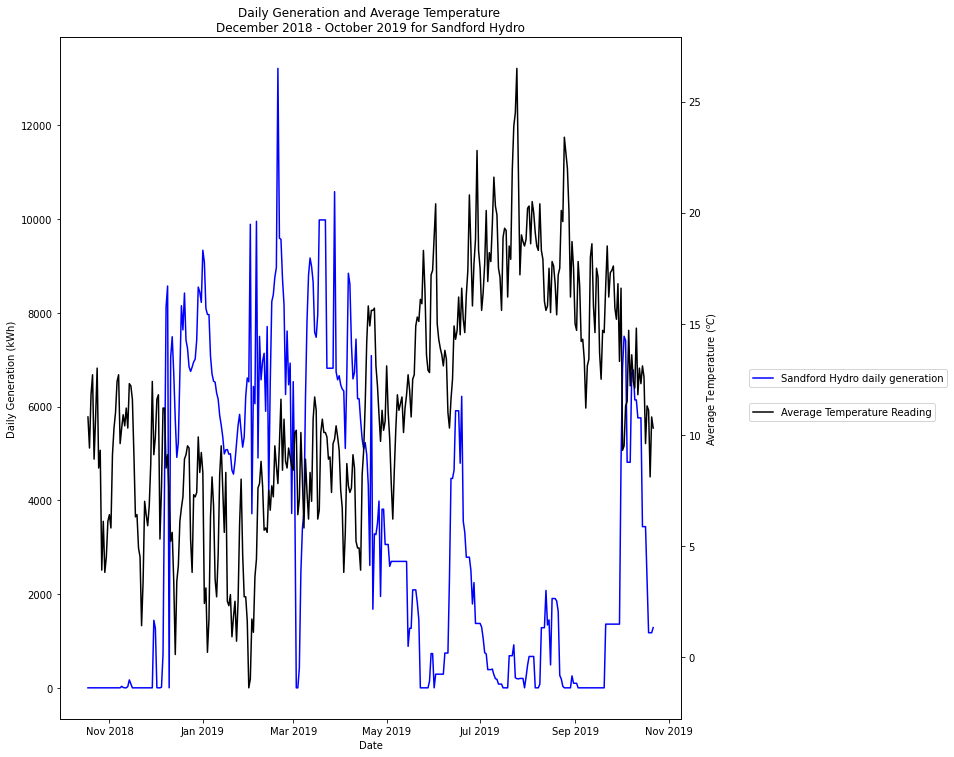

In [26]:
daily_gt_fig, daily_gt_ax = plt.subplots(figsize=(10, 10))            # gp means generation-precipitation
daily_gt_ax2 = daily_gt_ax.twinx()                                    # instantiate a second axes that shares the same x-axis

# Add x-axis and y-axis to the bar chart
# Overlaying the temperature data on top of the hydro generation data
daily_gt_ax.plot(merge['Date'].values, merge['Incremental Reading'], color='blue', label='Sandford Hydro daily generation')
daily_gt_ax2.plot(merge['Date'].values, merge['Daily Tmean °C'], color='k', label = 'Average Temperature Reading')
daily_gt_ax2.set_ylabel('Average Temperature $( ^o C)$')                              # we already handled the x-label with ax1

daily_gt_fig.tight_layout()                                                     # otherwise the right y-label is slightly clipped

# Set title and labels for axes
daily_gt_ax.set(xlabel= "Date", ylabel= "Daily Generation (kWh)", title= "Daily Generation and Average Temperature \nDecember 2018 - October 2019 for Sandford Hydro")

# Change the date format if we want
date_form = DateFormatter('%b %Y') #DateFormatter("%m-%d")
daily_gt_ax.xaxis.set_major_formatter(date_form)
daily_gt_ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
daily_gt_ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.45))
plt.show()

### Correlation Coefficient calculation


In [27]:
# filling all the NaN values within the columns with zeros
#merge['avg_level'] = merge['avg_level'].fillna(0)

In [28]:
# calculate Pearson's correlation between the generation data and the precipitation levels
corr_gt, _ = pearsonr(merge['Incremental Reading'], merge['Daily Tmean °C'])
print('Pearsons correlation: %.3f' % corr_gt)  

Pearsons correlation: -0.534


### Autocorrelation

Text(0.5, 1.0, 'Cross-correlation between daily generation and Mean Daily Temperature')

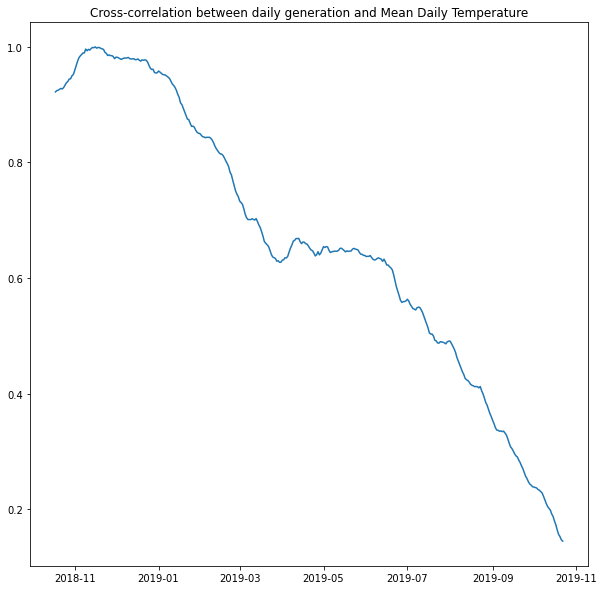

In [29]:
corr_gt = signal.correlate(merge['Incremental Reading'], merge['Daily Tmean °C'], mode = 'same')   
fig_corr_gt, ax_corr_gt = plt.subplots(figsize=(10, 10))   
ax_corr_gt.plot(merge['Date'], corr_gt / max(corr_gt))
ax_corr_gt.set_title('Cross-correlation between daily generation and Mean Daily Temperature')
# Change the date format if we want
#date_form = DateFormatter('%b %y') #DateFormatter("%m-%d")
#ax_corr1.xaxis.set_major_formatter(date_form)

# References

- https://www.real-statistics.com/statistics-tables/pearsons-correlation-table/